# Building an image classifier

This notebook is going to race through some high-level concepts in machine learning (specifically, fine-tuning a convolutional neural network). However, our focus will remain on demonstrating the practical uses of the Wellcome Collection API. As such, some important ML topics will be covered in less detail than they deserve, and some will be skipped entirely.
If you're not already familiar with the basics of ML but want to learn more, I'd recommend exploring [Practical Deep Learning for Coders](https://course.fast.ai/) by fast.ai. It describes itself as:

> A free course designed for people with some coding experience, who want to learn how to apply deep learning and machine learning to practical problems.

and will equip you with everything you need to understand and extend the code in this notebook.

## 7.1 Introduction

Image classification is a classic task in machine learning. By gathering thousands of examples of labelled images from a small number of classes, we can train a model to predict the class for new, unlabelled images.

In this notebook, we'll build a model that can classify images based on categories in the collection. We're going to use a pre-trained model, which has already been exposed to on a large collection of labelled images. We'll then re-train it on our own images, taking advantage of the low-level knowledge it gained from its previous task. This is a common technique in machine learning known as fine tuning, or transfer learning.

The model we'll fine-tune is called [ResNet-50](https://arxiv.org/abs/1512.03385), which has been pre-trained on the [ImageNet dataset](https://www.image-net.org/). We'll use the `transformers` library to download the pre-trained model, which uses `pytorch` under the hood.

In [1]:
!pip install -U --quiet transformers

zsh:1: command not found: pip


## 7.2 Gather an image dataset for fine-tuning

To fine-tune a model, we need a dataset of images that are labelled with the classes we want to predict. We'll use the Wellcome Collection API to gather a dataset of images from the collection, filtered by a set of subjects.

In [2]:
import requests
from tqdm.auto import tqdm
from pathlib import Path

from PIL import Image
from io import BytesIO

The categories we'll use are `portrait` and `landscape`. We want our model to learn the features of the images which contribute to their classification as portraits or landscapes. For example, portraits tend to contain features like hair, eyes, mouths, clothing, and their visual focus is usually concentrated on a single region of the image. Landscapes, however, contain features like trees, buildings, water, and their visual focus is usually spread across the image. Of course, the usual feature that distinguishes a portrait or landscape image is its aspect ratio, but our model won't have access to this information, either during training or when making predictions. We'll use square versions of the images throughout, so that the model has to make its decision based on the content of the image alone.

Let's start by defining a function which will download all of the images with a specified genre label.

In [3]:
base_url = "https://api.wellcomecollection.org/catalogue/v2/"


def get_genre_image_urls(genre):
    results = {}
    response = requests.get(
        base_url + "images",
        params={
            "source.genres.label": genre,
            "pageSize": "100",
        },
    ).json()

    progress_bar = tqdm(total=response["totalResults"])
    results.update(
        {
            result["id"]: result["thumbnail"]["url"].replace(
                "info.json", "full/!400,400/0/default.jpg"
            )
            for result in response["results"]
        }
    )
    progress_bar.update(len(response["results"]))

    while "nextPage" in response:
        response = requests.get(response["nextPage"]).json()
        results.update(
            {
                result["id"]: result["thumbnail"]["url"].replace(
                    "info.json", "full/!400,400/0/default.jpg"
                )
                for result in response["results"]
            }
        )
        progress_bar.update(len(response["results"]))

    progress_bar.close()
    return results

here are all of the image thumbnail urls which have the genre label 'portrait'

In [4]:
portrait_urls = get_genre_image_urls("Portrait prints")

  0%|          | 0/9558 [00:00<?, ?it/s]

and here are the landscapes.

In [5]:
landscape_urls = get_genre_image_urls("Landscape prints")

  0%|          | 0/337 [00:00<?, ?it/s]

In [6]:
len(portrait_urls), len(landscape_urls)

(9558, 337)

Let's save a local copy of the images to the `data/images` directory. We'll do some processing of the raw images later on, so we'll save the raw versions to the `data/images/raw` directory, with a subdirectory for each genre.

In [7]:
images_dir = Path("./data/images")
images_dir.mkdir(exist_ok=True, parents=True)

In [8]:
raw_portraits_dir = images_dir / "raw" / "portraits"
raw_portraits_dir.mkdir(exist_ok=True, parents=True)

if len(list(raw_portraits_dir.glob("*.jpg"))) == 0:
    for id, url in tqdm(portrait_urls.items()):
        response = requests.get(url)
        image = Image.open(BytesIO(response.content))
        image.save(raw_portraits_dir / f"{id}.jpg")

In [9]:
raw_landscapes_dir = images_dir / "raw" / "landscapes"
raw_landscapes_dir.mkdir(exist_ok=True, parents=True)

if len(list(raw_landscapes_dir.glob("*.jpg"))) == 0:
    for id, url in tqdm(landscape_urls.items()):
        response = requests.get(url)
        image = Image.open(BytesIO(response.content))
        image.save(raw_landscapes_dir / f"{id}.jpg")

## 7.3 Splitting the data into train, test, and validation sets

It's important that our model's accuracy is tested on images it hasn't seen before. To do this, we'll split our dataset into three sets:

- **Training set**: used to train the model.
- **Validation set**: used to test the model's accuracy during training.
- **Test set**: used to test the model's accuracy after training.

We'll use the `train_test_split` function from `sklearn` to split our dataset into a training set and a leftover set. We'll then split that leftover set into a training and a validation set.

First, let's set up some directories for our split datasets.

In [10]:
processed_images_dir = images_dir / "processed"

train_dir = processed_images_dir / "train"
(train_dir / "portraits").mkdir(exist_ok=True, parents=True)
(train_dir / "landscapes").mkdir(exist_ok=True, parents=True)

test_dir = processed_images_dir / "test"
(test_dir / "portraits").mkdir(exist_ok=True, parents=True)
(test_dir / "landscapes").mkdir(exist_ok=True, parents=True)

val_dir = processed_images_dir / "val"
(val_dir / "portraits").mkdir(exist_ok=True, parents=True)
(val_dir / "landscapes").mkdir(exist_ok=True, parents=True)

In [11]:
from sklearn.model_selection import train_test_split

train_size = 0.7
val_size = 0.05
test_size = 0.25

portraits_paths = list(raw_portraits_dir.glob("*.jpg"))

train_portraits_paths, leftover_portraits_paths = train_test_split(
    portraits_paths, train_size=train_size, random_state=42
)

val_portraits_paths, test_portraits_paths = train_test_split(
    leftover_portraits_paths,
    test_size=test_size / (test_size + val_size),
    random_state=42,
)


landscapes_paths = list(raw_landscapes_dir.glob("*.jpg"))
train_landscapes_paths, leftover_landscapes_paths = train_test_split(
    landscapes_paths, train_size=train_size, random_state=42
)

val_landscapes_paths, test_landscapes_paths = train_test_split(
    leftover_landscapes_paths,
    test_size=test_size / (test_size + val_size),
    random_state=42,
)

Now that we've set up our directories and split the paths into three sets, we can copy the images into the appropriate directories.

In [12]:
import shutil

for path in train_portraits_paths:
    shutil.copy(path, train_dir / "portraits")

for path in val_portraits_paths:
    shutil.copy(path, test_dir / "portraits")

for path in test_portraits_paths:
    shutil.copy(path, val_dir / "portraits")

## 7.4 Transforming images for training

We've created two image classes with visually distinct features (portraits and landscapes) which we should be able to use for training a model. However, our classes are very imbalanced!

In [13]:
# count the images in /data/images/raw/portraits
! ls -1 data/images/raw/portraits | wc -l 

    9534


In [14]:
# count the images in /data/images/raw/portraits
! ls -1 data/images/raw/landscapes | wc -l 

     337


We have more than 9000 portrait images, and only ~350 landscape images! This is a problem, because our model will learn much more from the portrait images than the landscapes. To limit this effect, we'll use a technique called data augmentation. This involves applying random transformations to the images in our training set, so that the model is exposed to a wider variety of images. We'll use `torchvision`'s `transforms` module to apply the following transformations:

- **Random rotation**: rotates the image by a random angle between -10 and 10 degrees.
- **Random resize and crop**: takes a random crop of the image between 50% and 100% of the original size, and resizing it to 400x400 pixels.
- **Random horizontal flip**: flips the image horizontally with a 50% probability.
- **Color jitter**: randomly changes the brightness, contrast, saturation, and hue of the image by 20%.

We'll apply these transformations to the images in our landscapes training set 10 times, and then save the transformed images alongside the originals.

In [15]:
from torchvision import transforms

transform = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(400, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2
        ),
    ]
)

for file in tqdm(train_landscapes_paths):
    image = Image.open(file)
    for i in range(10):
        transformed_image = transform(image)
        transformed_image.save(
            train_dir / "landscapes" / f"{file.stem}-{i}.jpg"
        )

for file in val_landscapes_paths:
    image = Image.open(file)
    for i in range(10):
        transformed_image = transform(image)
        transformed_image.save(val_dir / "landscapes" / f"{file.stem}-{i}.jpg")

for file in test_landscapes_paths:
    image = Image.open(file)
    for i in range(10):
        transformed_image = transform(image)
        transformed_image.save(test_dir / "landscapes" / f"{file.stem}-{i}.jpg")

  0%|          | 0/235 [00:00<?, ?it/s]

## 7.5 Building a `Dataset` using the processed images

Pytorch uses the `Dataset` and `Dataloader` objects to load images into a model for training. When the model asks for a batch of images, the `Dataloader` will load them from the `Dataset` and apply any transformations that have been specified. 

The `Dataset` here keeps track of all of the image paths, and when `__getitem__()` is called, loads the image and transforms it into a 224x224 `tensor`, along with a tensor representing the class of the image. The `Dataloader` then batches these tensors together and feeds them to the model.

In [16]:
from transformers import ResNetForImageClassification
import torch
from torch.utils.data import DataLoader, Dataset

In [17]:
class ImageDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.classes = sorted(
            [
                image_class.name
                for image_class in data_dir.glob("*")
                if not image_class.name.startswith(".")
            ]
        )
        self.image_transforms = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]
        )

    def get_target_tensor(self, image_path):
        target_tensor = torch.zeros(len(self.classes))
        target_tensor[self.classes.index(image_path.parent.name)] = 1
        return target_tensor

    def __len__(self):
        return len(list(self.data_dir.glob("**/*.jpg")))

    def __getitem__(self, idx):
        image_path = list(self.data_dir.glob("**/*.jpg"))[idx]
        image = Image.open(image_path)
        image_tensor = self.image_transforms(image)
        target_tensor = self.get_target_tensor(image_path)
        return image_tensor, target_tensor

Let's create a `Dataset` and `DataLoader` for each of our training, validation, and test sets.

In [18]:
train_dataset = ImageDataset(train_dir)
val_dataset = ImageDataset(val_dir)
test_dataset = ImageDataset(test_dir)

In [19]:
batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=0,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=0,
)

## 7.6 Creating the model for fine-tuning

Now we can create the model we'll use for fine-tuning. We'll use a pre-trained `resnet50` model from `torchvision`. Because this network has been trained on the ImageNet dataset, its last layer is 1000 neurons wide, with each one representing a different class. We'll replace this layer with a new layer which has two outputs, one for each of our new classes.

We'll also freeze all of the layers except the final layer, so that only the final layer is trained during fine-tuning. This has the dual effect of 
- retaining all of the lower-level features that the model learned during its training on ImageNet, and 
- massively speeding up the transfer learning process, because we only have to train a single layer.

We'll use the `Adam` optimizer to train the model, and the `CrossEntropyLoss` function to calculate the loss at each step.

In [20]:
from torch.nn.functional import cross_entropy
from torch import nn


model_name = "microsoft/resnet-50"

model = ResNetForImageClassification.from_pretrained(model_name)

# replace the original classifier head with a linear layer,
# squashing the output down to 2 classes
model.classifier = nn.Sequential(
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=2048, out_features=2, bias=True),
)

# freeze all the layers except the classifier head
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [21]:
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

## 7.7 Training the model

For each batch, we'll run the image tensors through the model, calculate the loss, and then backpropagate the loss through the model to update the weights. At the end of each epoch, we'll calculate the accuracy of the model's classifications against the validation set. 

For now, we'll just train the model for one epoch. We'll display the training and validation losses and accuracies, and keep track of them so that we can plot the whole thing later on.

In [22]:
n_epochs = 1

train_losses = []

for epoch in range(n_epochs):
    model.train()
    train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch}")
    for image_tensors, targets in train_progress_bar:
        optimiser.zero_grad()

        predicted_classes = model.forward(image_tensors)
        loss = cross_entropy(predicted_classes.logits, targets)

        loss.backward()
        optimiser.step()

        train_losses.append(loss.item())
        train_loss = sum(train_losses[-10:]) / len(train_losses[-10:])
        train_progress_bar.set_description(f"Train loss: {train_loss:.3f}")

    val_losses = []
    val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch}")
    for image_tensors, targets in val_progress_bar:
        model.eval()
        predicted_classes = model.forward(image_tensors)
        loss = cross_entropy(predicted_classes.logits, targets)
        val_losses.append(loss.item())
        mean_val_loss = sum(val_losses) / len(val_losses)
        val_progress_bar.set_description(
            f"Train loss: {train_loss:.3f} Validation loss: {mean_val_loss:.3f}"
        )

Epoch 0:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/80 [00:00<?, ?it/s]

## 7.8 Plotting the training loss

Let's have a look at the rolling mean of the training loss.

<Axes: >

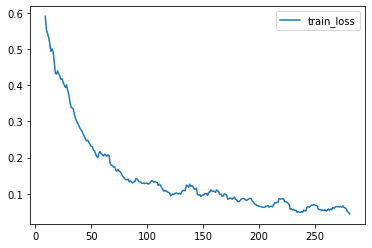

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

train_losses_df = pd.DataFrame(train_losses, columns=["train_loss"])
rolling_train_losses_df = train_losses_df.rolling(10).mean()
rolling_train_losses_df.plot()

We can also use our newly trained model in evaluation mode to make predictions on the test set. We'll work our way through the test set, and for each image, we'll predict the class and compare it to the actual class. We'll then calculate the accuracy of the model's predictions, and display the results as a classification report and a confusion matrix.

In [24]:

model.eval()

y_true = []
y_predicted = []

for image_tensors, targets in tqdm(test_dataloader):
    predicted_classes = model.forward(image_tensors)
    predicted_labels = predicted_classes.logits.argmax(dim=1)
    y_true.extend(targets.argmax(dim=1).tolist())
    y_predicted.extend(predicted_labels.tolist())

  0%|          | 0/42 [00:00<?, ?it/s]

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       850
           1       0.96      1.00      0.98       476

    accuracy                           0.98      1326
   macro avg       0.98      0.99      0.98      1326
weighted avg       0.98      0.98      0.98      1326



With a minimal amount of training data, and without any custom feature engineering, we were able to train a model that can classify images of portraits and landscapes with 98% accuracy! This is pretty remarkable, considering the fact that we didn't have to specify any rules or features for telling the computer how to tell the difference between the classes.

We can visualise the classification metrics differently, using a confusion matrix. We can use it to see which classes are getting confused, i.e., whether the model is misclassifying portraits as landscapes or vice versa.

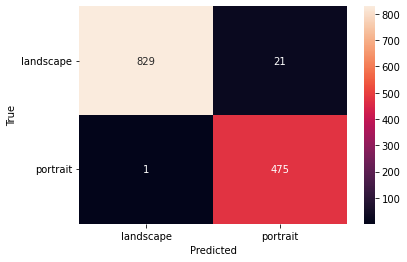

In [27]:
cm = confusion_matrix(y_true, y_predicted)
sns.heatmap(cm, annot=True, fmt="d")

plt.xlabel("Predicted")
plt.xticks([0.5, 1.5], ["landscape", "portrait"])

plt.ylabel("True")
plt.yticks([0.5, 1.5], ["landscape", "portrait"], rotation=0)

plt.show()

## 7.9 Inspecting the model's predictions

Let's have a look at some random images from the test set, and see how the model classifies them.

In [28]:
import random

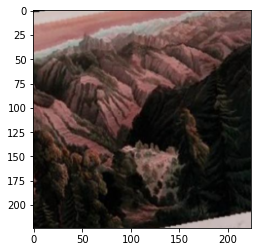

Probabilities: [0.8507626056671143, 0.14923731982707977]
True: landscapes
Predicted: landscapes


In [29]:
# get a real image from the test set and run it through the model
dataset = test_dataloader.dataset
image_tensor, target_tensor = random.choice(dataset)
predicted_classes = model.forward(image_tensor.unsqueeze(0))
prediction = predicted_classes.logits

# show the image
plt.imshow(image_tensor.permute(1, 2, 0))
plt.show()

# print the probabilities and the predicted class
print("Probabilities:", prediction.softmax(dim=1).squeeze().tolist())
print("True:", dataset.classes[target_tensor.argmax().item()])
print("Predicted:", dataset.classes[prediction.argmax().item()])

By inspecting the predicted probabilities for each class and the true labels, we can look directly at the images where the model is most/least confident in its predictions, and, most interestingly, the images which it gets most wrong!

In [ ]:
# find the images in the test set which the model has misclassified

confused_indexes = [
    index
    for index, (y_true, y_pred) in enumerate(zip(y_true, y_predicted))
    if y_true != y_pred
]

len(confused_indexes)

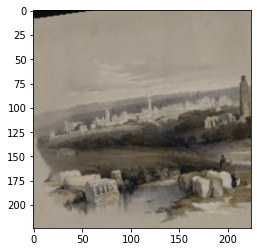

Probabilities: [0.4764188826084137, 0.5235811471939087]
True: landscape
Predicted: portrait


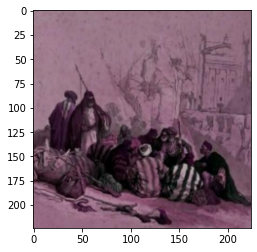

Probabilities: [0.2630021274089813, 0.7369979023933411]
True: landscape
Predicted: portrait


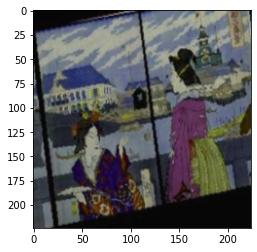

Probabilities: [0.4529586732387543, 0.5470412969589233]
True: landscape
Predicted: portrait


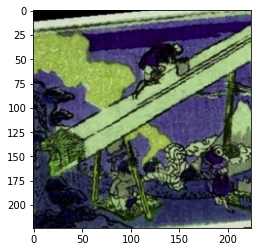

Probabilities: [0.47856250405311584, 0.5214375257492065]
True: landscape
Predicted: portrait


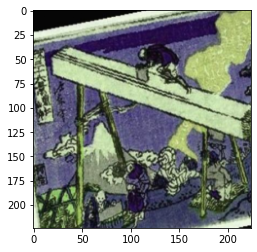

Probabilities: [0.3433268070220947, 0.6566731929779053]
True: landscape
Predicted: portrait


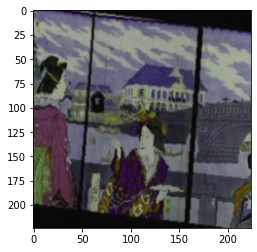

Probabilities: [0.4245135486125946, 0.575486421585083]
True: landscape
Predicted: portrait


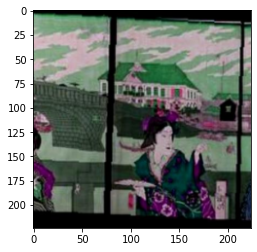

Probabilities: [0.4093392789363861, 0.5906606912612915]
True: landscape
Predicted: portrait


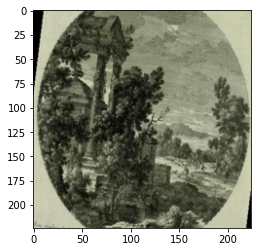

Probabilities: [0.4787518382072449, 0.5212481617927551]
True: landscape
Predicted: portrait


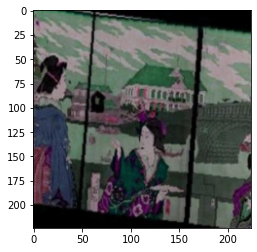

Probabilities: [0.49415692687034607, 0.5058430433273315]
True: landscape
Predicted: portrait


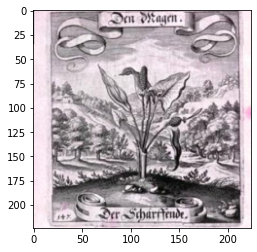

Probabilities: [0.43163129687309265, 0.568368673324585]
True: landscape
Predicted: portrait


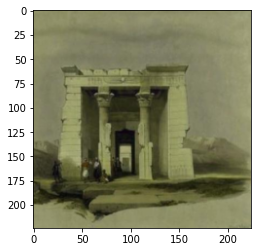

Probabilities: [0.4912942349910736, 0.5087058544158936]
True: landscape
Predicted: portrait


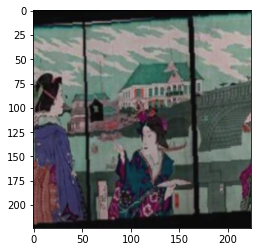

Probabilities: [0.34542083740234375, 0.6545791029930115]
True: landscape
Predicted: portrait


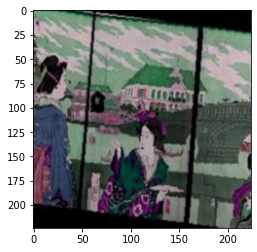

Probabilities: [0.38949525356292725, 0.6105047464370728]
True: landscape
Predicted: portrait


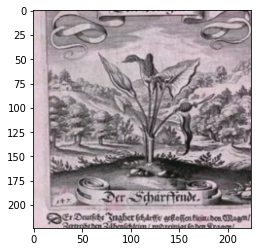

Probabilities: [0.4792538583278656, 0.5207460522651672]
True: landscape
Predicted: portrait


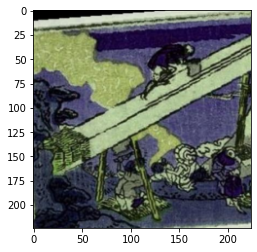

Probabilities: [0.3770406246185303, 0.6229593753814697]
True: landscape
Predicted: portrait


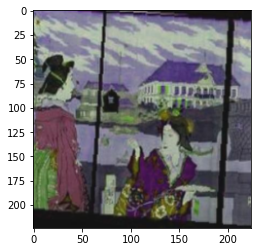

Probabilities: [0.4017883837223053, 0.5982116460800171]
True: landscape
Predicted: portrait


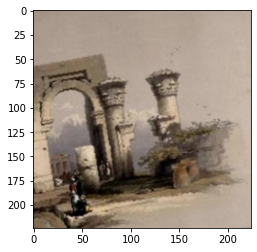

Probabilities: [0.48985686898231506, 0.5101431608200073]
True: landscape
Predicted: portrait


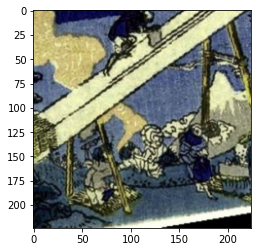

Probabilities: [0.2965998947620392, 0.7034001350402832]
True: landscape
Predicted: portrait


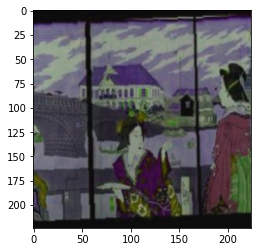

Probabilities: [0.2399442195892334, 0.7600557804107666]
True: landscape
Predicted: portrait


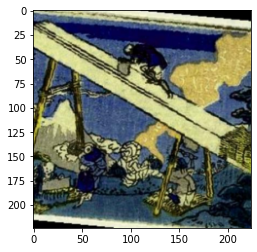

Probabilities: [0.48882555961608887, 0.5111744403839111]
True: landscape
Predicted: portrait


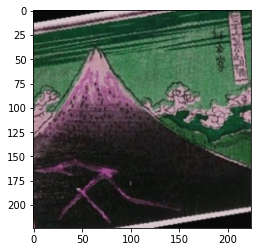

Probabilities: [0.272458016872406, 0.727541983127594]
True: landscape
Predicted: portrait


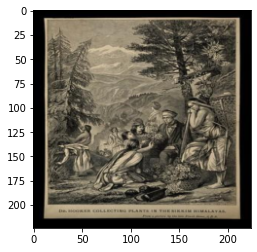

Probabilities: [0.5520161986351013, 0.44798386096954346]
True: portrait
Predicted: landscape


In [31]:
# show the images where the model got confused

for index in confused_indexes:
    image_tensor, true_label = test_dataset[index]
    prediction = model.forward(image_tensor.unsqueeze(0)).logits
    predicted_label = prediction.argmax(dim=1)

    # show the image
    plt.imshow(image_tensor.permute(1, 2, 0))
    plt.show()

    # show the predicted class
    classes = {0: "landscape", 1: "portrait"}

    print("Probabilities:", prediction.softmax(dim=1).squeeze().tolist())
    print("True:", classes[true_label.argmax().item()])
    print("Predicted:", classes[predicted_label.item()])

A lot of those misclassifications are quite understandable - I might have guessed that some of those portraits were landscapes, too. We could use these misclassifications to improve our model, but that's beyond the scope of this notebook.

# Exercises

1. Adapt this notebook to classify a different pair of subjects
2. Adapt the code to classify more than two subjects!
3. Try using a different pre-trained model from `torchvision.models`
4. Balance the class weights used by the optimiser by using [sklearn's `compute_class_weight` function](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html)